In [28]:
%matplotlib widget
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [29]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

import pandas as pd
from os.path import abspath

import warnings
warnings.filterwarnings("ignore")

In [30]:
df = pd.read_csv(abspath('../../../data/MSFT/MSFT-5-Year.csv'), index_col=0, parse_dates=['Date'])

df.columns.name = df.index.name
df.index.name = None

df = df.filter(['Date', 'Open'])
print(df.shape)
df.head()

(1245, 1)


Date,Open
2017-03-01,64.129997
2017-03-02,64.690002
2017-03-03,63.990002
2017-03-06,63.970001
2017-03-07,64.190002


In [31]:
# Split the df into a training set and a test set
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
train_set, test_set = train_test_split(df, test_size=0.05, shuffle=False)

n_features = 1

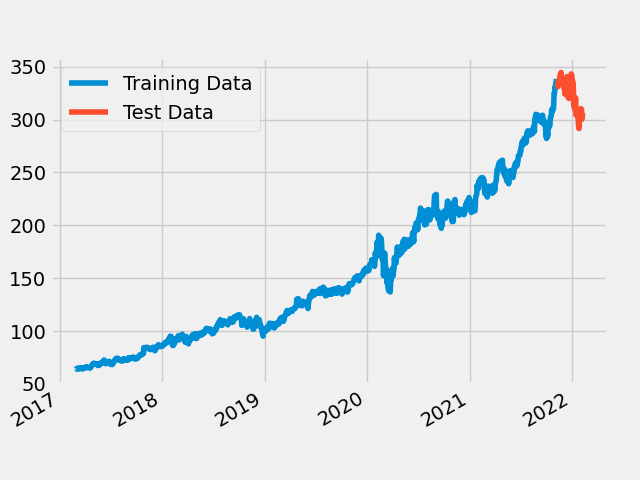

In [32]:
# Plot the training and testing data
train_set.Open.plot(label='Training Data')
test_set.Open.plot(label='Test Data')
plt.legend()

In [33]:
from sklearn.preprocessing import MinMaxScaler

transformer = MinMaxScaler()
train_scaled = transformer.fit_transform(train_set)
test_scaled = transformer.fit_transform(test_set)

In [34]:
import tensorflow as tf

#List attached GPU devices
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [35]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator # type: ignore

n_input = 60

train_generator=TimeseriesGenerator(train_scaled,
                                     train_scaled,
                                      length=n_input,
                                      batch_size=32)

In [36]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, GRU

GRU_UNITS = 20

model = Sequential()
model.add(GRU(units=GRU_UNITS, input_shape=(n_input, n_features)))
model.add(Dense(units=1))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_2 (GRU)                 (None, 20)                1380      
                                                                 
 dense_2 (Dense)             (None, 1)                 21        
                                                                 
Total params: 1,401
Trainable params: 1,401
Non-trainable params: 0
_________________________________________________________________


In [37]:
# Create an EarlyStopping callback
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='loss', patience=5)

In [38]:
import wandb
from wandb.keras import WandbCallback

wandb.init(project="stock-predictions", entity="alpheron", magic=True)

wandb.config = {
  "learning_rate": 0.001,
  "epochs": 100,
  "batch_size": 32,
  "lstm_units": GRU_UNITS
}

Problem at: /var/folders/0b/s1_0vjp13r521rnhstpnxpg00000gp/T/ipykernel_95880/2531723536.py 4 <module>


KeyboardInterrupt: 

Thread HandlerThread:
Traceback (most recent call last):
  File "/usr/local/Caskroom/miniconda/base/envs/StockMarket/lib/python3.8/site-packages/wandb/sdk/internal/internal_util.py", line 54, in run
    self._run()
  File "/usr/local/Caskroom/miniconda/base/envs/StockMarket/lib/python3.8/site-packages/wandb/sdk/internal/internal_util.py", line 105, in _run
    self._process(record)
  File "/usr/local/Caskroom/miniconda/base/envs/StockMarket/lib/python3.8/site-packages/wandb/sdk/internal/internal.py", line 260, in _process
    self._hm.handle(record)
  File "/usr/local/Caskroom/miniconda/base/envs/StockMarket/lib/python3.8/site-packages/wandb/sdk/internal/handler.py", line 123, in handle
    handler(record)
  File "/usr/local/Caskroom/miniconda/base/envs/StockMarket/lib/python3.8/site-packages/wandb/sdk/internal/handler.py", line 133, in handle_request
    handler(record)
  File "/usr/local/Caskroom/miniconda/base/envs/StockMarket/lib/python3.8/site-packages/wandb/sdk/internal/handler.p

In [40]:
from keras.metrics import RootMeanSquaredError
from tensorflow_addons.optimizers import RectifiedAdam

model.compile(optimizer=RectifiedAdam(), loss='mean_squared_error', metrics=[RootMeanSquaredError()])
model.fit(train_generator, epochs=2, callbacks=[early_stopping])

Epoch 1/2
36/36 [==============================] - 6s 169ms/step - loss: 0.0246 - root_mean_squared_error: 0.1569
Epoch 2/2
36/36 [==============================] - 6s 164ms/step - loss: 0.0159 - root_mean_squared_error: 0.1261


In [41]:
model.save(abspath('../../../logs/MSFT-5-Year-GRU/'))

2022-02-27 13:35:39.808365: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /Users/aditya/Programming/stock-market-predictions/logs/MSFT-5-Year-GRU/assets


INFO:tensorflow:Assets written to: /Users/aditya/Programming/stock-market-predictions/logs/MSFT-5-Year-GRU/assets


In [ ]:
inputs = df[len(df)-len(test_set)-60 : ].values
inputs = inputs.reshape(-1,1)
inputs = transformer.transform(inputs)

In [ ]:
import numpy as np

x_test = []
for i in range(60,len(inputs)):
    x_test.append(inputs[i-60:i, 0])
    
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
print(x_test.shape)

In [ ]:
predicted = model.predict(x_test)
predicted = transformer.inverse_transform(predicted)

In [ ]:
print(predicted.shape)

# Convert the predicted values to a dataframe
predicted_df = pd.DataFrame(predicted)

# Rename the column to "Open"
predicted_df.columns = ['Open']

# Add a new column called "Date" that has the same index as the other dataframe
predicted_df['Date'] = df[len(df)-len(test_set)-0 : ].index

# Set the 'Date' column as the index
predicted_df = predicted_df.set_index('Date')

predicted_df.head()

In [ ]:
# Plot the predicted values
predicted_df.plot(label='Predicted')

In [ ]:
def plot_predictions(test, predicted):
    plt.figure(4, figsize=(10,6))
    plt.plot(test, color="red", label="real MSFT stock price")
    plt.plot(predicted, color="blue", label="predicted stock price")
    plt.title("MSFT stock price prediction")
    plt.xlabel("time")
    plt.ylabel("MSFT stock price")
    plt.legend()
    plt.show()

plot_predictions(test_set, predicted_df)

In [ ]:
import math
from sklearn.metrics import mean_squared_error

def return_rmse(test, predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("the root mean squared error is: {}".format(rmse))
    return rmse

RMSE = return_rmse(test_set, predicted)

In [ ]:
wandb.run.summary["root_mean_squared_error"] = RMSE